In [1]:
!pip install git+https://github.com/google-research/torchsde.git

  Cloning https://github.com/google-research/torchsde.git to ./pip-req-build-4sn7zwgd
  Running command git clone -q https://github.com/google-research/torchsde.git '/data/home/AI4OAC-VM1/notebooks/AI4OAC/Untitled Folder 1/pip-req-build-4sn7zwgd'
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for torchsde: filename=torchsde-0.2.4-cp36-none-any.whl size=55585 sha256=f3fba5582708f1805c33259683b2fbe436a20adbb9f6893febfd7386af2a2d58
  Stored in directory: /data/home/AI4OAC-VM1/notebooks/AI4OAC/Untitled Folder 1/pip-ephem-wheel-cache-rj6hbq9x/wheels/31/b5/4b/53c7d7c124c1bbfebd2c5f429ca86b5e59f6cd4718dc0f1229
Successfully built torchsde


In [2]:
import random
import numpy as np
import torch
import torchsde
import matplotlib.pyplot as plt 
import numpy as np
def manual_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
manual_seed(0)

In [3]:
batch_size, state_size, brownian_size = 100, 2, 1
t_size = 1000

class SDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'

    def __init__(self):
        super().__init__()
        A = np.random.uniform(size=(state_size,state_size))
        A[0,0] = 0
        A[0,1] = 80
        A[1,0] = -80
        A[1,1] = 0
        self.A = torch.nn.Parameter(data=torch.from_numpy(A).float(), requires_grad=True)
        B = np.random.uniform(size=(state_size ,state_size ))
        B[0,0] = 2
        B[1,1] = 1
        B[0,1] = 0
        B[1,0] = 0        
        self.B = torch.nn.Parameter(data=torch.from_numpy(B).float(), requires_grad=True)*0.5
        self.imag_eigen = False
    def f(self, t, y):
        if self.imag_eigen:
                A = (self.A-self.A.T)/2
        else:
                A = self.A
        return torch.nn.functional.linear(y,A)  # shape (batch_size, state_size)

    def g(self, t, y):
        return torch.nn.functional.linear(y,self.B).view(batch_size, 
                                  state_size)

sde = SDE()
y0 = torch.full((batch_size, state_size), 5.0)
ts = torch.linspace(0, 0.5, t_size)
# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, y0, ts,method = 'srk')

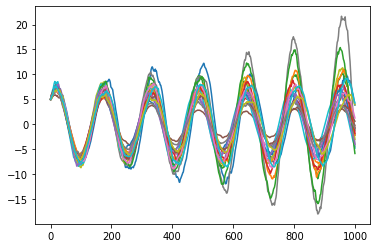

In [4]:
plt.plot(ys.detach()[:,:20,0])

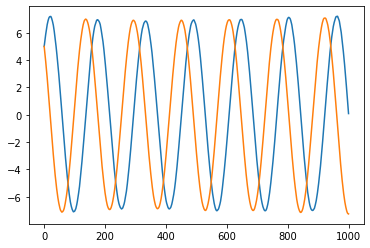

In [5]:
plt.plot(ys.detach()[:,:,0].mean(dim = -1))
plt.plot(ys.detach()[:,:,1].mean(dim = -1))

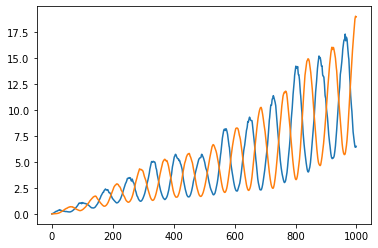

In [6]:
plt.plot(ys.detach()[:2000,:,0].var(dim = -1))
plt.plot(ys.detach()[:2000,:,1].var(dim = -1))

In [7]:
class Latent_SDE_Unknown(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'

    def __init__(self):
        super().__init__()
        y_aug = np.random.uniform(size=(8,100,100,1))*0.0
        self.y_aug = torch.nn.Parameter(data=torch.from_numpy(y_aug).float(), requires_grad=True)
        A = np.random.uniform(size=(state_size,state_size))
        self.A = torch.nn.Parameter(data=torch.from_numpy(A).float(), requires_grad=True)
        B = np.random.uniform(size=(state_size * brownian_size,state_size ))*0.1
        self.B = torch.nn.Parameter(data=torch.from_numpy(B).float(), requires_grad=True)
        self.imag_eigen = True
    def f(self, t, y):
        if self.imag_eigen:
                A = (self.A-self.A.T)/2
        else:
                A = self.A
        return torch.nn.functional.linear(y,A)  # shape (batch_size, state_size)

    def g(self, t, y):
        return torch.nn.functional.linear(y,self.B).view(y.shape[0], 
                                  state_size)

latent_sde_model = Latent_SDE_Unknown()

In [8]:
X_train = ys.detach().clone()[:800,:,:1].reshape(8,100,100,1)
ts_batched = ts[:800].reshape(8,100)
X_test  = ys.detach().clone()[800:,:,:]
bm = (torchsde.BrownianInterval(t0=0.0, t1=ts[800], size=(1, state_size), levy_area_approximation = 'space-time'))
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(latent_sde_model.parameters(),lr = 0.1)

In [9]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.1
for t in range(500):
    for b in range(8):
        inp_conc = torch.cat((X_train[b,:,:,:],latent_sde_model.y_aug[b,:,:,:]),dim = -1)
        y_hat = torchsde.sdeint(latent_sde_model, inp_conc[0,:,:], ts_batched[b], method = 'srk')#,bm = bm)
        loss = ((inp_conc[:,:,:1].mean(dim = 1)-y_hat[:,:,:1].mean(dim = 1))**2).mean()+((inp_conc[:,:,:1].var(dim = 1)-y_hat[:,:,:1].var(dim = 1))**2).mean()# + criterion(y_hat.std(dim = 1), X_train[:100,:,:].std(dim = 1))
        print(t,loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

0 tensor(42.8160, grad_fn=<AddBackward0>)
0 tensor(98.7352, grad_fn=<AddBackward0>)
0 tensor(59.6866, grad_fn=<AddBackward0>)
0 tensor(21.0190, grad_fn=<AddBackward0>)
0 tensor(69.6236, grad_fn=<AddBackward0>)
0 tensor(98.3624, grad_fn=<AddBackward0>)
0 tensor(48.0294, grad_fn=<AddBackward0>)
0 tensor(46.3155, grad_fn=<AddBackward0>)
1 tensor(43.4672, grad_fn=<AddBackward0>)
1 tensor(98.7922, grad_fn=<AddBackward0>)
1 tensor(59.8750, grad_fn=<AddBackward0>)
1 tensor(20.9057, grad_fn=<AddBackward0>)
1 tensor(73.4237, grad_fn=<AddBackward0>)
1 tensor(98.5704, grad_fn=<AddBackward0>)
1 tensor(47.3420, grad_fn=<AddBackward0>)
1 tensor(46.6472, grad_fn=<AddBackward0>)
2 tensor(41.8995, grad_fn=<AddBackward0>)
2 tensor(97.2869, grad_fn=<AddBackward0>)
2 tensor(59.6290, grad_fn=<AddBackward0>)
2 tensor(20.8844, grad_fn=<AddBackward0>)
2 tensor(70.8406, grad_fn=<AddBackward0>)
2 tensor(96.7313, grad_fn=<AddBackward0>)
2 tensor(47.4373, grad_fn=<AddBackward0>)
2 tensor(46.2807, grad_fn=<AddBack

24 tensor(16.8968, grad_fn=<AddBackward0>)
24 tensor(18.5247, grad_fn=<AddBackward0>)
24 tensor(17.5572, grad_fn=<AddBackward0>)
24 tensor(11.1424, grad_fn=<AddBackward0>)
24 tensor(24.3959, grad_fn=<AddBackward0>)
24 tensor(25.8388, grad_fn=<AddBackward0>)
24 tensor(24.3326, grad_fn=<AddBackward0>)
25 tensor(8.4405, grad_fn=<AddBackward0>)
25 tensor(14.7920, grad_fn=<AddBackward0>)
25 tensor(18.3589, grad_fn=<AddBackward0>)
25 tensor(17.5201, grad_fn=<AddBackward0>)
25 tensor(9.2090, grad_fn=<AddBackward0>)
25 tensor(23.2517, grad_fn=<AddBackward0>)
25 tensor(24.6636, grad_fn=<AddBackward0>)
25 tensor(24.3566, grad_fn=<AddBackward0>)
26 tensor(8.2044, grad_fn=<AddBackward0>)
26 tensor(12.6906, grad_fn=<AddBackward0>)
26 tensor(17.6491, grad_fn=<AddBackward0>)
26 tensor(17.5153, grad_fn=<AddBackward0>)
26 tensor(8.3560, grad_fn=<AddBackward0>)
26 tensor(22.2762, grad_fn=<AddBackward0>)
26 tensor(25.1720, grad_fn=<AddBackward0>)
26 tensor(23.5670, grad_fn=<AddBackward0>)
27 tensor(7.982

48 tensor(15.7615, grad_fn=<AddBackward0>)
48 tensor(17.1806, grad_fn=<AddBackward0>)
48 tensor(3.8844, grad_fn=<AddBackward0>)
48 tensor(11.7461, grad_fn=<AddBackward0>)
48 tensor(22.7607, grad_fn=<AddBackward0>)
48 tensor(23.9030, grad_fn=<AddBackward0>)
49 tensor(7.8588, grad_fn=<AddBackward0>)
49 tensor(3.2540, grad_fn=<AddBackward0>)
49 tensor(16.0841, grad_fn=<AddBackward0>)
49 tensor(17.0835, grad_fn=<AddBackward0>)
49 tensor(3.8083, grad_fn=<AddBackward0>)
49 tensor(11.3994, grad_fn=<AddBackward0>)
49 tensor(22.5927, grad_fn=<AddBackward0>)
49 tensor(23.5568, grad_fn=<AddBackward0>)
50 tensor(7.9145, grad_fn=<AddBackward0>)
50 tensor(3.3486, grad_fn=<AddBackward0>)
50 tensor(15.7672, grad_fn=<AddBackward0>)
50 tensor(16.8717, grad_fn=<AddBackward0>)
50 tensor(3.6484, grad_fn=<AddBackward0>)
50 tensor(11.6039, grad_fn=<AddBackward0>)
50 tensor(22.3031, grad_fn=<AddBackward0>)
50 tensor(23.5033, grad_fn=<AddBackward0>)
51 tensor(7.7488, grad_fn=<AddBackward0>)
51 tensor(3.3075, g

72 tensor(16.8216, grad_fn=<AddBackward0>)
72 tensor(3.5965, grad_fn=<AddBackward0>)
72 tensor(11.0006, grad_fn=<AddBackward0>)
72 tensor(21.9359, grad_fn=<AddBackward0>)
72 tensor(23.3895, grad_fn=<AddBackward0>)
73 tensor(7.7612, grad_fn=<AddBackward0>)
73 tensor(3.1919, grad_fn=<AddBackward0>)
73 tensor(15.4953, grad_fn=<AddBackward0>)
73 tensor(16.8511, grad_fn=<AddBackward0>)
73 tensor(3.6442, grad_fn=<AddBackward0>)
73 tensor(11.0604, grad_fn=<AddBackward0>)
73 tensor(21.8635, grad_fn=<AddBackward0>)
73 tensor(23.1534, grad_fn=<AddBackward0>)
74 tensor(7.7771, grad_fn=<AddBackward0>)
74 tensor(3.2168, grad_fn=<AddBackward0>)
74 tensor(15.7193, grad_fn=<AddBackward0>)
74 tensor(16.8092, grad_fn=<AddBackward0>)
74 tensor(3.5914, grad_fn=<AddBackward0>)
74 tensor(11.3197, grad_fn=<AddBackward0>)
74 tensor(21.8920, grad_fn=<AddBackward0>)
74 tensor(23.5501, grad_fn=<AddBackward0>)
75 tensor(7.7586, grad_fn=<AddBackward0>)
75 tensor(3.1993, grad_fn=<AddBackward0>)
75 tensor(15.5092, g

96 tensor(3.6033, grad_fn=<AddBackward0>)
96 tensor(11.0126, grad_fn=<AddBackward0>)
96 tensor(21.0833, grad_fn=<AddBackward0>)
96 tensor(23.4158, grad_fn=<AddBackward0>)
97 tensor(7.6681, grad_fn=<AddBackward0>)
97 tensor(3.0598, grad_fn=<AddBackward0>)
97 tensor(15.2933, grad_fn=<AddBackward0>)
97 tensor(16.6301, grad_fn=<AddBackward0>)
97 tensor(3.5113, grad_fn=<AddBackward0>)
97 tensor(10.9154, grad_fn=<AddBackward0>)
97 tensor(21.3849, grad_fn=<AddBackward0>)
97 tensor(23.6206, grad_fn=<AddBackward0>)
98 tensor(7.7191, grad_fn=<AddBackward0>)
98 tensor(3.0863, grad_fn=<AddBackward0>)
98 tensor(15.3555, grad_fn=<AddBackward0>)
98 tensor(16.6241, grad_fn=<AddBackward0>)
98 tensor(3.5672, grad_fn=<AddBackward0>)
98 tensor(11.0128, grad_fn=<AddBackward0>)
98 tensor(21.2445, grad_fn=<AddBackward0>)
98 tensor(23.4934, grad_fn=<AddBackward0>)
99 tensor(7.6602, grad_fn=<AddBackward0>)
99 tensor(3.1045, grad_fn=<AddBackward0>)
99 tensor(15.3183, grad_fn=<AddBackward0>)
99 tensor(16.6506, g

120 tensor(3.0253, grad_fn=<AddBackward0>)
120 tensor(15.1117, grad_fn=<AddBackward0>)
120 tensor(16.4245, grad_fn=<AddBackward0>)
120 tensor(3.5158, grad_fn=<AddBackward0>)
120 tensor(10.7462, grad_fn=<AddBackward0>)
120 tensor(20.6958, grad_fn=<AddBackward0>)
120 tensor(23.4544, grad_fn=<AddBackward0>)
121 tensor(7.5774, grad_fn=<AddBackward0>)
121 tensor(3.0280, grad_fn=<AddBackward0>)
121 tensor(15.1041, grad_fn=<AddBackward0>)
121 tensor(16.4031, grad_fn=<AddBackward0>)
121 tensor(3.4770, grad_fn=<AddBackward0>)
121 tensor(10.7560, grad_fn=<AddBackward0>)
121 tensor(20.5468, grad_fn=<AddBackward0>)
121 tensor(23.5095, grad_fn=<AddBackward0>)
122 tensor(7.5770, grad_fn=<AddBackward0>)
122 tensor(3.0453, grad_fn=<AddBackward0>)
122 tensor(15.0451, grad_fn=<AddBackward0>)
122 tensor(16.3842, grad_fn=<AddBackward0>)
122 tensor(3.4697, grad_fn=<AddBackward0>)
122 tensor(10.7164, grad_fn=<AddBackward0>)
122 tensor(20.5329, grad_fn=<AddBackward0>)
122 tensor(23.5027, grad_fn=<AddBackward

143 tensor(10.5146, grad_fn=<AddBackward0>)
143 tensor(19.6243, grad_fn=<AddBackward0>)
143 tensor(23.6184, grad_fn=<AddBackward0>)
144 tensor(7.4324, grad_fn=<AddBackward0>)
144 tensor(2.8746, grad_fn=<AddBackward0>)
144 tensor(14.8131, grad_fn=<AddBackward0>)
144 tensor(16.1320, grad_fn=<AddBackward0>)
144 tensor(3.3288, grad_fn=<AddBackward0>)
144 tensor(10.5991, grad_fn=<AddBackward0>)
144 tensor(19.8345, grad_fn=<AddBackward0>)
144 tensor(24.1913, grad_fn=<AddBackward0>)
145 tensor(7.3892, grad_fn=<AddBackward0>)
145 tensor(2.9490, grad_fn=<AddBackward0>)
145 tensor(14.6838, grad_fn=<AddBackward0>)
145 tensor(16.0921, grad_fn=<AddBackward0>)
145 tensor(3.4020, grad_fn=<AddBackward0>)
145 tensor(10.4326, grad_fn=<AddBackward0>)
145 tensor(19.7396, grad_fn=<AddBackward0>)
145 tensor(23.9708, grad_fn=<AddBackward0>)
146 tensor(7.3985, grad_fn=<AddBackward0>)
146 tensor(2.9941, grad_fn=<AddBackward0>)
146 tensor(14.7123, grad_fn=<AddBackward0>)
146 tensor(16.0775, grad_fn=<AddBackward

167 tensor(2.7025, grad_fn=<AddBackward0>)
167 tensor(14.1789, grad_fn=<AddBackward0>)
167 tensor(15.5906, grad_fn=<AddBackward0>)
167 tensor(3.2675, grad_fn=<AddBackward0>)
167 tensor(10.0384, grad_fn=<AddBackward0>)
167 tensor(18.5910, grad_fn=<AddBackward0>)
167 tensor(23.5042, grad_fn=<AddBackward0>)
168 tensor(7.1389, grad_fn=<AddBackward0>)
168 tensor(2.7183, grad_fn=<AddBackward0>)
168 tensor(14.1481, grad_fn=<AddBackward0>)
168 tensor(15.5721, grad_fn=<AddBackward0>)
168 tensor(3.2391, grad_fn=<AddBackward0>)
168 tensor(9.9086, grad_fn=<AddBackward0>)
168 tensor(18.5751, grad_fn=<AddBackward0>)
168 tensor(23.4053, grad_fn=<AddBackward0>)
169 tensor(7.1517, grad_fn=<AddBackward0>)
169 tensor(2.7413, grad_fn=<AddBackward0>)
169 tensor(14.0892, grad_fn=<AddBackward0>)
169 tensor(15.5752, grad_fn=<AddBackward0>)
169 tensor(3.3058, grad_fn=<AddBackward0>)
169 tensor(10.0827, grad_fn=<AddBackward0>)
169 tensor(18.4479, grad_fn=<AddBackward0>)
169 tensor(23.2601, grad_fn=<AddBackward0

190 tensor(17.3432, grad_fn=<AddBackward0>)
190 tensor(23.5330, grad_fn=<AddBackward0>)
191 tensor(6.8440, grad_fn=<AddBackward0>)
191 tensor(2.4427, grad_fn=<AddBackward0>)
191 tensor(13.1846, grad_fn=<AddBackward0>)
191 tensor(14.7899, grad_fn=<AddBackward0>)
191 tensor(2.9675, grad_fn=<AddBackward0>)
191 tensor(9.3387, grad_fn=<AddBackward0>)
191 tensor(17.5142, grad_fn=<AddBackward0>)
191 tensor(23.3620, grad_fn=<AddBackward0>)
192 tensor(6.7102, grad_fn=<AddBackward0>)
192 tensor(2.4877, grad_fn=<AddBackward0>)
192 tensor(13.1784, grad_fn=<AddBackward0>)
192 tensor(14.7377, grad_fn=<AddBackward0>)
192 tensor(3.0443, grad_fn=<AddBackward0>)
192 tensor(9.3034, grad_fn=<AddBackward0>)
192 tensor(17.2474, grad_fn=<AddBackward0>)
192 tensor(23.1935, grad_fn=<AddBackward0>)
193 tensor(6.7490, grad_fn=<AddBackward0>)
193 tensor(2.3746, grad_fn=<AddBackward0>)
193 tensor(13.1027, grad_fn=<AddBackward0>)
193 tensor(14.6856, grad_fn=<AddBackward0>)
193 tensor(2.9233, grad_fn=<AddBackward0>)

214 tensor(13.1214, grad_fn=<AddBackward0>)
214 tensor(2.5548, grad_fn=<AddBackward0>)
214 tensor(9.3632, grad_fn=<AddBackward0>)
214 tensor(15.1880, grad_fn=<AddBackward0>)
214 tensor(22.9982, grad_fn=<AddBackward0>)
215 tensor(6.0299, grad_fn=<AddBackward0>)
215 tensor(2.1303, grad_fn=<AddBackward0>)
215 tensor(11.2449, grad_fn=<AddBackward0>)
215 tensor(13.0599, grad_fn=<AddBackward0>)
215 tensor(2.6707, grad_fn=<AddBackward0>)
215 tensor(8.8746, grad_fn=<AddBackward0>)
215 tensor(15.4802, grad_fn=<AddBackward0>)
215 tensor(22.6289, grad_fn=<AddBackward0>)
216 tensor(5.9143, grad_fn=<AddBackward0>)
216 tensor(2.0098, grad_fn=<AddBackward0>)
216 tensor(11.2086, grad_fn=<AddBackward0>)
216 tensor(12.8726, grad_fn=<AddBackward0>)
216 tensor(2.6147, grad_fn=<AddBackward0>)
216 tensor(7.9959, grad_fn=<AddBackward0>)
216 tensor(15.1626, grad_fn=<AddBackward0>)
216 tensor(22.8911, grad_fn=<AddBackward0>)
217 tensor(5.9047, grad_fn=<AddBackward0>)
217 tensor(1.9684, grad_fn=<AddBackward0>)


238 tensor(3.3748, grad_fn=<AddBackward0>)
238 tensor(1.0864, grad_fn=<AddBackward0>)
238 tensor(5.9578, grad_fn=<AddBackward0>)
238 tensor(7.2410, grad_fn=<AddBackward0>)
238 tensor(1.4419, grad_fn=<AddBackward0>)
238 tensor(4.5771, grad_fn=<AddBackward0>)
238 tensor(8.4930, grad_fn=<AddBackward0>)
238 tensor(15.8678, grad_fn=<AddBackward0>)
239 tensor(3.1919, grad_fn=<AddBackward0>)
239 tensor(1.4169, grad_fn=<AddBackward0>)
239 tensor(6.4784, grad_fn=<AddBackward0>)
239 tensor(7.0825, grad_fn=<AddBackward0>)
239 tensor(1.3148, grad_fn=<AddBackward0>)
239 tensor(4.0281, grad_fn=<AddBackward0>)
239 tensor(12.1034, grad_fn=<AddBackward0>)
239 tensor(17.5240, grad_fn=<AddBackward0>)
240 tensor(3.2076, grad_fn=<AddBackward0>)
240 tensor(1.1553, grad_fn=<AddBackward0>)
240 tensor(5.6131, grad_fn=<AddBackward0>)
240 tensor(6.4410, grad_fn=<AddBackward0>)
240 tensor(1.8692, grad_fn=<AddBackward0>)
240 tensor(3.3293, grad_fn=<AddBackward0>)
240 tensor(9.1270, grad_fn=<AddBackward0>)
240 tens

261 tensor(3.4784, grad_fn=<AddBackward0>)
262 tensor(0.2392, grad_fn=<AddBackward0>)
262 tensor(0.2433, grad_fn=<AddBackward0>)
262 tensor(0.4016, grad_fn=<AddBackward0>)
262 tensor(0.4274, grad_fn=<AddBackward0>)
262 tensor(0.3861, grad_fn=<AddBackward0>)
262 tensor(0.5227, grad_fn=<AddBackward0>)
262 tensor(0.5188, grad_fn=<AddBackward0>)
262 tensor(2.6494, grad_fn=<AddBackward0>)
263 tensor(0.2679, grad_fn=<AddBackward0>)
263 tensor(0.2230, grad_fn=<AddBackward0>)
263 tensor(0.2175, grad_fn=<AddBackward0>)
263 tensor(0.2910, grad_fn=<AddBackward0>)
263 tensor(0.2923, grad_fn=<AddBackward0>)
263 tensor(0.9472, grad_fn=<AddBackward0>)
263 tensor(0.3407, grad_fn=<AddBackward0>)
263 tensor(1.4777, grad_fn=<AddBackward0>)
264 tensor(0.1848, grad_fn=<AddBackward0>)
264 tensor(0.2563, grad_fn=<AddBackward0>)
264 tensor(0.2246, grad_fn=<AddBackward0>)
264 tensor(0.2985, grad_fn=<AddBackward0>)
264 tensor(0.5799, grad_fn=<AddBackward0>)
264 tensor(0.3376, grad_fn=<AddBackward0>)
264 tensor(

285 tensor(0.0807, grad_fn=<AddBackward0>)
285 tensor(0.7956, grad_fn=<AddBackward0>)
286 tensor(0.0267, grad_fn=<AddBackward0>)
286 tensor(0.0663, grad_fn=<AddBackward0>)
286 tensor(0.1315, grad_fn=<AddBackward0>)
286 tensor(0.0581, grad_fn=<AddBackward0>)
286 tensor(0.5627, grad_fn=<AddBackward0>)
286 tensor(0.9505, grad_fn=<AddBackward0>)
286 tensor(0.2210, grad_fn=<AddBackward0>)
286 tensor(0.4596, grad_fn=<AddBackward0>)
287 tensor(0.0347, grad_fn=<AddBackward0>)
287 tensor(0.0489, grad_fn=<AddBackward0>)
287 tensor(0.0792, grad_fn=<AddBackward0>)
287 tensor(0.1218, grad_fn=<AddBackward0>)
287 tensor(2.0414, grad_fn=<AddBackward0>)
287 tensor(1.2455, grad_fn=<AddBackward0>)
287 tensor(0.0784, grad_fn=<AddBackward0>)
287 tensor(0.9098, grad_fn=<AddBackward0>)
288 tensor(0.0737, grad_fn=<AddBackward0>)
288 tensor(0.0183, grad_fn=<AddBackward0>)
288 tensor(0.0227, grad_fn=<AddBackward0>)
288 tensor(0.1743, grad_fn=<AddBackward0>)
288 tensor(0.2381, grad_fn=<AddBackward0>)
288 tensor(

309 tensor(0.2864, grad_fn=<AddBackward0>)
309 tensor(0.1288, grad_fn=<AddBackward0>)
309 tensor(1.1277, grad_fn=<AddBackward0>)
310 tensor(0.0242, grad_fn=<AddBackward0>)
310 tensor(0.1008, grad_fn=<AddBackward0>)
310 tensor(0.0918, grad_fn=<AddBackward0>)
310 tensor(0.2387, grad_fn=<AddBackward0>)
310 tensor(0.1848, grad_fn=<AddBackward0>)
310 tensor(0.9082, grad_fn=<AddBackward0>)
310 tensor(1.0011, grad_fn=<AddBackward0>)
310 tensor(0.3124, grad_fn=<AddBackward0>)
311 tensor(0.0687, grad_fn=<AddBackward0>)
311 tensor(0.0603, grad_fn=<AddBackward0>)
311 tensor(0.2989, grad_fn=<AddBackward0>)
311 tensor(0.1018, grad_fn=<AddBackward0>)
311 tensor(0.1302, grad_fn=<AddBackward0>)
311 tensor(0.7423, grad_fn=<AddBackward0>)
311 tensor(0.2949, grad_fn=<AddBackward0>)
311 tensor(0.2447, grad_fn=<AddBackward0>)
312 tensor(0.0730, grad_fn=<AddBackward0>)
312 tensor(0.1584, grad_fn=<AddBackward0>)
312 tensor(0.0301, grad_fn=<AddBackward0>)
312 tensor(0.0623, grad_fn=<AddBackward0>)
312 tensor(

333 tensor(0.1060, grad_fn=<AddBackward0>)
333 tensor(0.7924, grad_fn=<AddBackward0>)
333 tensor(1.6675, grad_fn=<AddBackward0>)
333 tensor(0.9400, grad_fn=<AddBackward0>)
334 tensor(0.0539, grad_fn=<AddBackward0>)
334 tensor(0.3048, grad_fn=<AddBackward0>)
334 tensor(0.2022, grad_fn=<AddBackward0>)
334 tensor(0.0569, grad_fn=<AddBackward0>)
334 tensor(0.3118, grad_fn=<AddBackward0>)
334 tensor(0.8765, grad_fn=<AddBackward0>)
334 tensor(0.3918, grad_fn=<AddBackward0>)
334 tensor(0.3994, grad_fn=<AddBackward0>)
335 tensor(0.0374, grad_fn=<AddBackward0>)
335 tensor(0.1893, grad_fn=<AddBackward0>)
335 tensor(0.2939, grad_fn=<AddBackward0>)
335 tensor(0.1542, grad_fn=<AddBackward0>)
335 tensor(0.6029, grad_fn=<AddBackward0>)
335 tensor(0.4383, grad_fn=<AddBackward0>)
335 tensor(0.3027, grad_fn=<AddBackward0>)
335 tensor(0.5562, grad_fn=<AddBackward0>)
336 tensor(0.1481, grad_fn=<AddBackward0>)
336 tensor(0.2341, grad_fn=<AddBackward0>)
336 tensor(0.2214, grad_fn=<AddBackward0>)
336 tensor(

357 tensor(0.1027, grad_fn=<AddBackward0>)
357 tensor(0.2454, grad_fn=<AddBackward0>)
357 tensor(0.7714, grad_fn=<AddBackward0>)
357 tensor(0.1017, grad_fn=<AddBackward0>)
357 tensor(0.7416, grad_fn=<AddBackward0>)
358 tensor(0.0529, grad_fn=<AddBackward0>)
358 tensor(0.1078, grad_fn=<AddBackward0>)
358 tensor(0.0477, grad_fn=<AddBackward0>)
358 tensor(0.0902, grad_fn=<AddBackward0>)
358 tensor(0.2315, grad_fn=<AddBackward0>)
358 tensor(0.5830, grad_fn=<AddBackward0>)
358 tensor(0.0964, grad_fn=<AddBackward0>)
358 tensor(1.0874, grad_fn=<AddBackward0>)
359 tensor(0.0367, grad_fn=<AddBackward0>)
359 tensor(0.1005, grad_fn=<AddBackward0>)
359 tensor(0.1119, grad_fn=<AddBackward0>)
359 tensor(0.1106, grad_fn=<AddBackward0>)
359 tensor(0.1632, grad_fn=<AddBackward0>)
359 tensor(0.1872, grad_fn=<AddBackward0>)
359 tensor(0.1470, grad_fn=<AddBackward0>)
359 tensor(0.7141, grad_fn=<AddBackward0>)
360 tensor(0.0470, grad_fn=<AddBackward0>)
360 tensor(0.1640, grad_fn=<AddBackward0>)
360 tensor(

381 tensor(0.0480, grad_fn=<AddBackward0>)
381 tensor(0.1306, grad_fn=<AddBackward0>)
381 tensor(0.3066, grad_fn=<AddBackward0>)
381 tensor(1.1458, grad_fn=<AddBackward0>)
381 tensor(0.1015, grad_fn=<AddBackward0>)
381 tensor(0.3415, grad_fn=<AddBackward0>)
382 tensor(0.0330, grad_fn=<AddBackward0>)
382 tensor(0.0600, grad_fn=<AddBackward0>)
382 tensor(0.1077, grad_fn=<AddBackward0>)
382 tensor(0.1464, grad_fn=<AddBackward0>)
382 tensor(0.3688, grad_fn=<AddBackward0>)
382 tensor(0.4497, grad_fn=<AddBackward0>)
382 tensor(0.6395, grad_fn=<AddBackward0>)
382 tensor(0.4891, grad_fn=<AddBackward0>)
383 tensor(0.0385, grad_fn=<AddBackward0>)
383 tensor(0.0413, grad_fn=<AddBackward0>)
383 tensor(0.0388, grad_fn=<AddBackward0>)
383 tensor(0.1485, grad_fn=<AddBackward0>)
383 tensor(0.7172, grad_fn=<AddBackward0>)
383 tensor(0.4062, grad_fn=<AddBackward0>)
383 tensor(0.7390, grad_fn=<AddBackward0>)
383 tensor(2.5819, grad_fn=<AddBackward0>)
384 tensor(0.0763, grad_fn=<AddBackward0>)
384 tensor(

405 tensor(0.2123, grad_fn=<AddBackward0>)
405 tensor(0.0651, grad_fn=<AddBackward0>)
405 tensor(0.0724, grad_fn=<AddBackward0>)
405 tensor(0.2962, grad_fn=<AddBackward0>)
405 tensor(0.9504, grad_fn=<AddBackward0>)
405 tensor(0.2702, grad_fn=<AddBackward0>)
405 tensor(0.9178, grad_fn=<AddBackward0>)
406 tensor(0.0192, grad_fn=<AddBackward0>)
406 tensor(0.0588, grad_fn=<AddBackward0>)
406 tensor(0.0553, grad_fn=<AddBackward0>)
406 tensor(0.1204, grad_fn=<AddBackward0>)
406 tensor(0.4175, grad_fn=<AddBackward0>)
406 tensor(0.6235, grad_fn=<AddBackward0>)
406 tensor(0.2764, grad_fn=<AddBackward0>)
406 tensor(0.8715, grad_fn=<AddBackward0>)
407 tensor(0.0870, grad_fn=<AddBackward0>)
407 tensor(0.0752, grad_fn=<AddBackward0>)
407 tensor(0.0548, grad_fn=<AddBackward0>)
407 tensor(0.1569, grad_fn=<AddBackward0>)
407 tensor(0.6621, grad_fn=<AddBackward0>)
407 tensor(1.4562, grad_fn=<AddBackward0>)
407 tensor(0.2153, grad_fn=<AddBackward0>)
407 tensor(1.3502, grad_fn=<AddBackward0>)
408 tensor(

429 tensor(0.0429, grad_fn=<AddBackward0>)
429 tensor(0.1072, grad_fn=<AddBackward0>)
429 tensor(0.0589, grad_fn=<AddBackward0>)
429 tensor(0.1377, grad_fn=<AddBackward0>)
429 tensor(0.4081, grad_fn=<AddBackward0>)
429 tensor(0.8690, grad_fn=<AddBackward0>)
429 tensor(0.1876, grad_fn=<AddBackward0>)
429 tensor(0.4153, grad_fn=<AddBackward0>)
430 tensor(0.0526, grad_fn=<AddBackward0>)
430 tensor(0.0298, grad_fn=<AddBackward0>)
430 tensor(0.0336, grad_fn=<AddBackward0>)
430 tensor(0.0300, grad_fn=<AddBackward0>)
430 tensor(0.3350, grad_fn=<AddBackward0>)
430 tensor(1.1725, grad_fn=<AddBackward0>)
430 tensor(0.1651, grad_fn=<AddBackward0>)
430 tensor(0.4664, grad_fn=<AddBackward0>)
431 tensor(0.0151, grad_fn=<AddBackward0>)
431 tensor(0.1273, grad_fn=<AddBackward0>)
431 tensor(0.1683, grad_fn=<AddBackward0>)
431 tensor(0.0754, grad_fn=<AddBackward0>)
431 tensor(0.2227, grad_fn=<AddBackward0>)
431 tensor(0.9563, grad_fn=<AddBackward0>)
431 tensor(0.2830, grad_fn=<AddBackward0>)
431 tensor(

452 tensor(1.6578, grad_fn=<AddBackward0>)
453 tensor(0.0801, grad_fn=<AddBackward0>)
453 tensor(0.0737, grad_fn=<AddBackward0>)
453 tensor(0.1436, grad_fn=<AddBackward0>)
453 tensor(0.2030, grad_fn=<AddBackward0>)
453 tensor(0.3255, grad_fn=<AddBackward0>)
453 tensor(1.4579, grad_fn=<AddBackward0>)
453 tensor(0.2902, grad_fn=<AddBackward0>)
453 tensor(1.1605, grad_fn=<AddBackward0>)
454 tensor(0.0630, grad_fn=<AddBackward0>)
454 tensor(0.0594, grad_fn=<AddBackward0>)
454 tensor(0.0196, grad_fn=<AddBackward0>)
454 tensor(0.0715, grad_fn=<AddBackward0>)
454 tensor(0.4268, grad_fn=<AddBackward0>)
454 tensor(0.3703, grad_fn=<AddBackward0>)
454 tensor(0.1268, grad_fn=<AddBackward0>)
454 tensor(0.3913, grad_fn=<AddBackward0>)
455 tensor(0.0684, grad_fn=<AddBackward0>)
455 tensor(0.0670, grad_fn=<AddBackward0>)
455 tensor(0.1159, grad_fn=<AddBackward0>)
455 tensor(0.2501, grad_fn=<AddBackward0>)
455 tensor(0.1353, grad_fn=<AddBackward0>)
455 tensor(0.8095, grad_fn=<AddBackward0>)
455 tensor(

476 tensor(0.1705, grad_fn=<AddBackward0>)
476 tensor(0.5366, grad_fn=<AddBackward0>)
477 tensor(0.0309, grad_fn=<AddBackward0>)
477 tensor(0.0630, grad_fn=<AddBackward0>)
477 tensor(0.0273, grad_fn=<AddBackward0>)
477 tensor(0.0384, grad_fn=<AddBackward0>)
477 tensor(0.4169, grad_fn=<AddBackward0>)
477 tensor(0.6654, grad_fn=<AddBackward0>)
477 tensor(0.2194, grad_fn=<AddBackward0>)
477 tensor(0.4940, grad_fn=<AddBackward0>)
478 tensor(0.0292, grad_fn=<AddBackward0>)
478 tensor(0.2305, grad_fn=<AddBackward0>)
478 tensor(0.0263, grad_fn=<AddBackward0>)
478 tensor(0.1176, grad_fn=<AddBackward0>)
478 tensor(0.4417, grad_fn=<AddBackward0>)
478 tensor(0.4154, grad_fn=<AddBackward0>)
478 tensor(0.1469, grad_fn=<AddBackward0>)
478 tensor(0.7713, grad_fn=<AddBackward0>)
479 tensor(0.0474, grad_fn=<AddBackward0>)
479 tensor(0.0468, grad_fn=<AddBackward0>)
479 tensor(0.0184, grad_fn=<AddBackward0>)
479 tensor(0.1641, grad_fn=<AddBackward0>)
479 tensor(0.4115, grad_fn=<AddBackward0>)
479 tensor(

In [10]:
inp_conc = torch.cat((X_train[0,:,:,:],latent_sde_model.y_aug[0,:,:,:]),dim = -1)
y_hat = torchsde.sdeint(latent_sde_model, inp_conc[0,:,:], ts)

WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


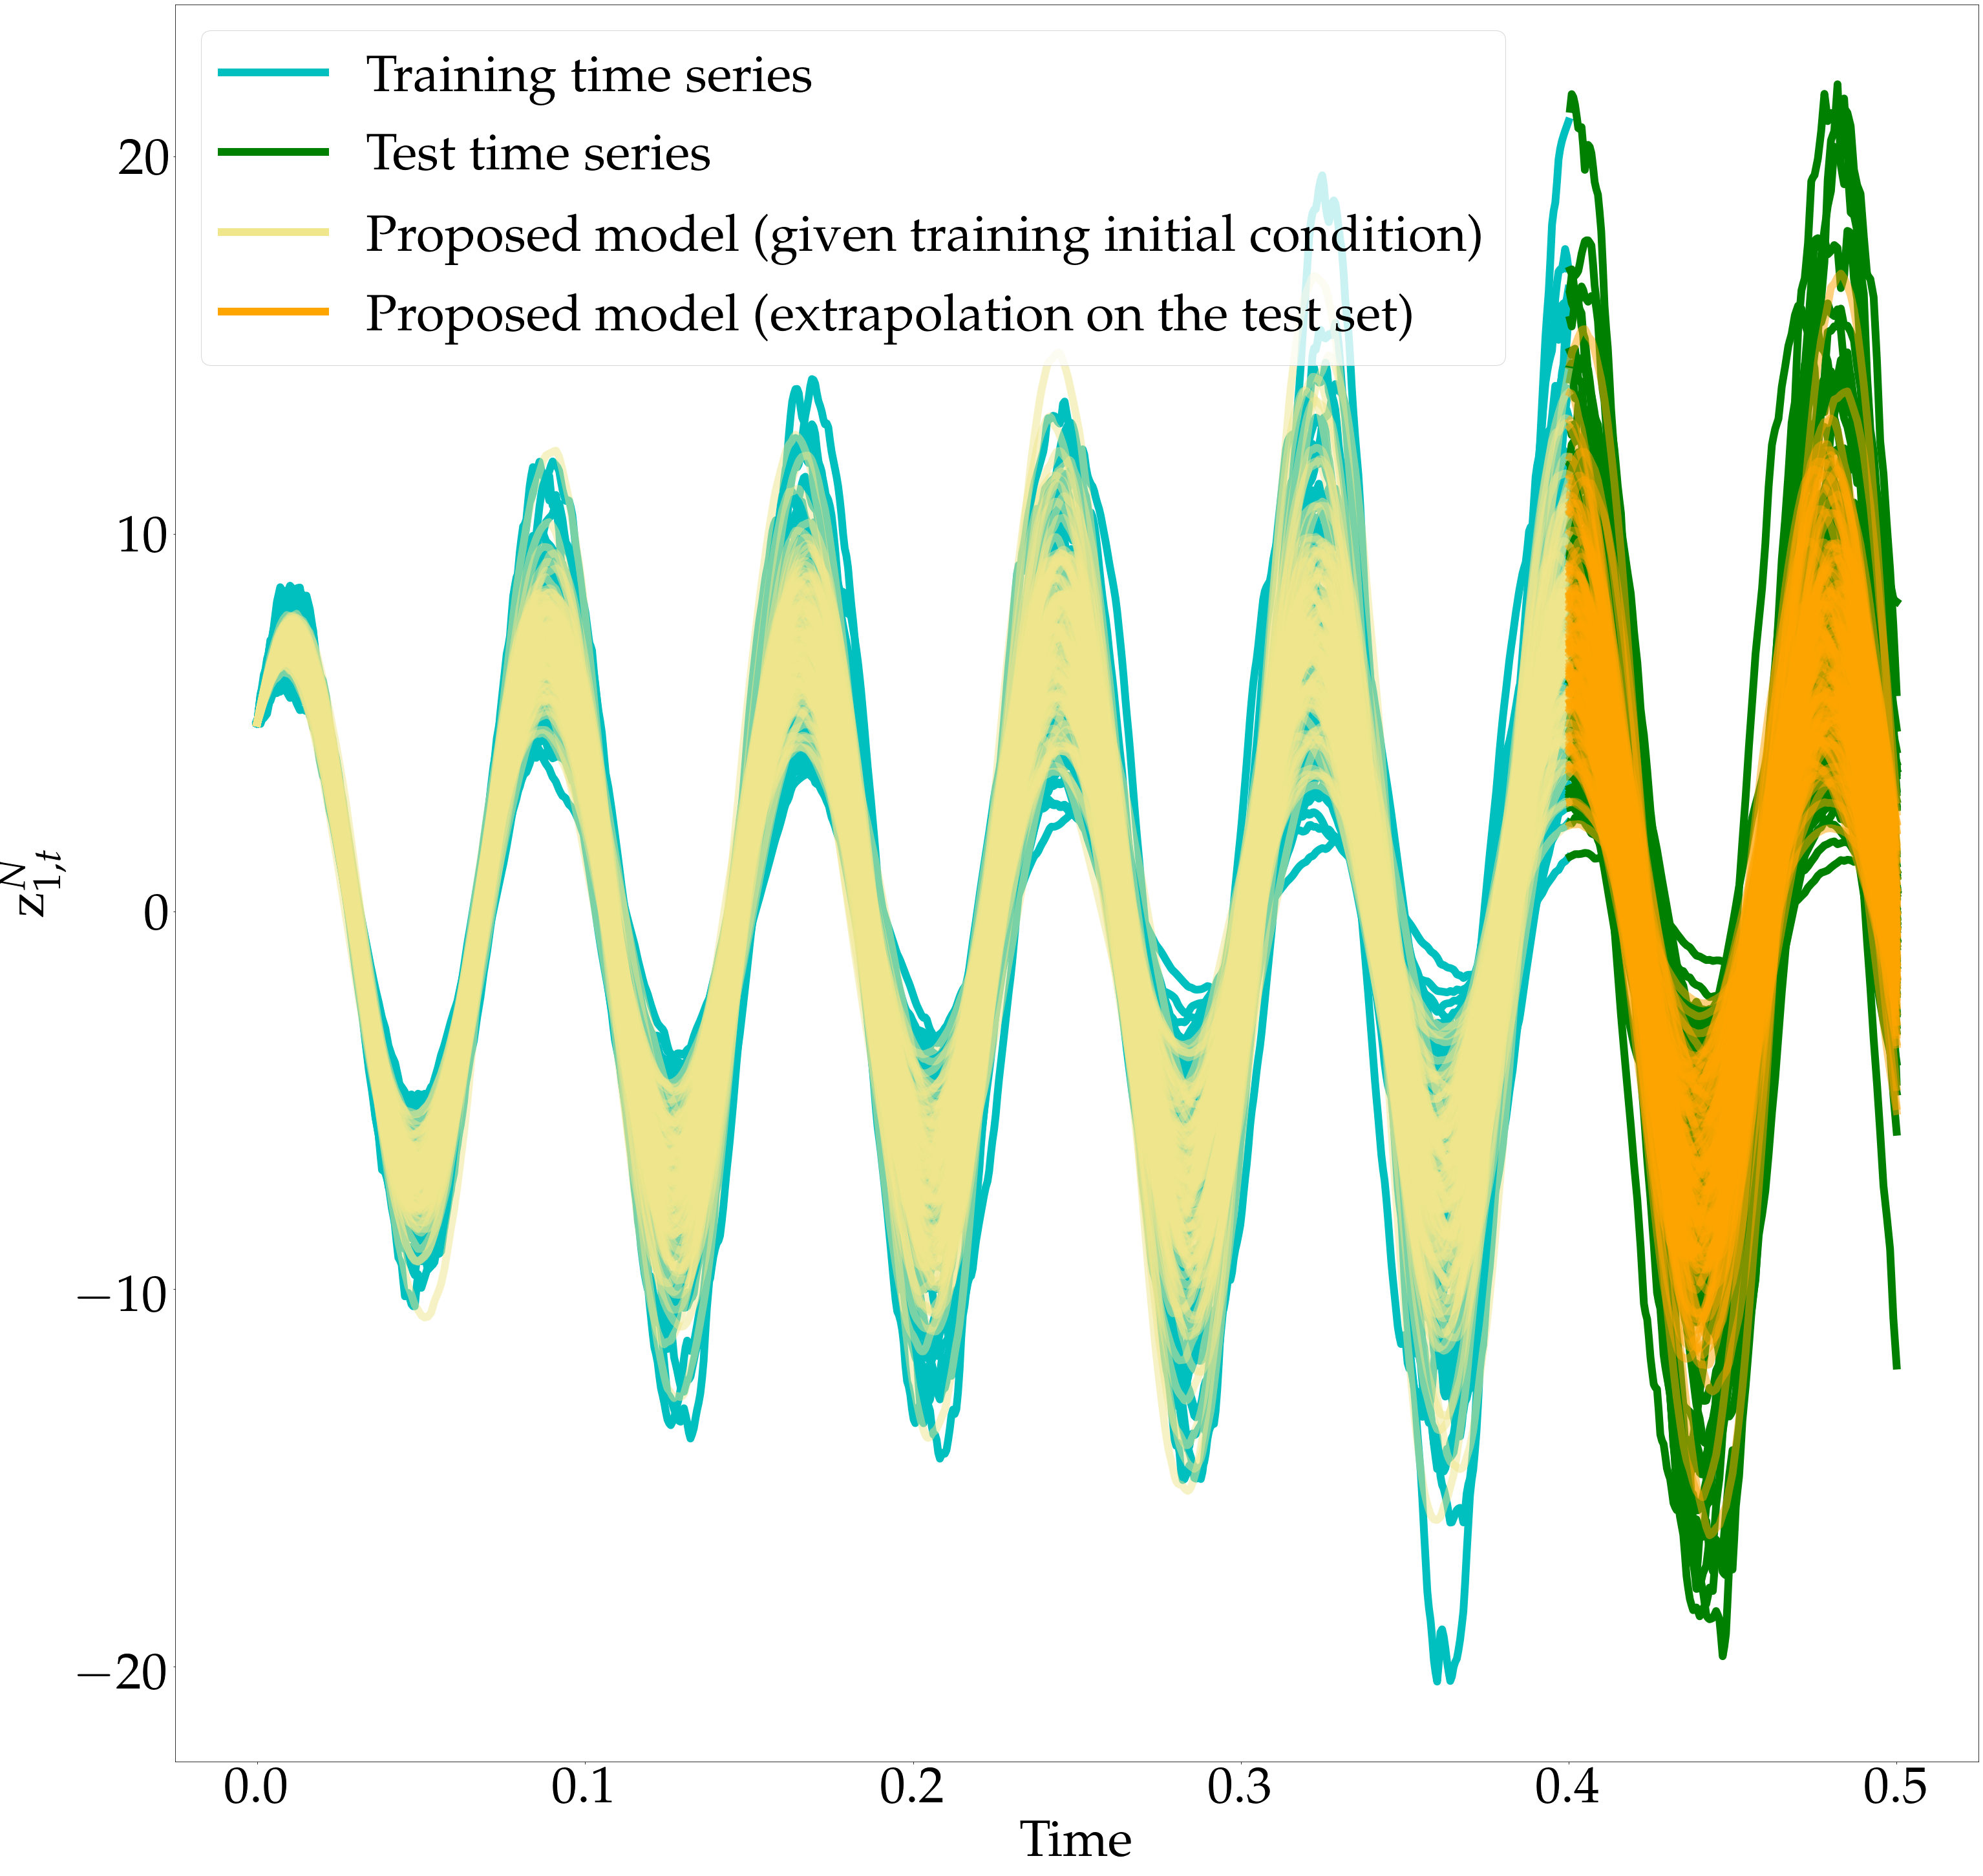

In [11]:
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 80})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fig=plt.figure(figsize=(50,50))

train_series     = np.zeros_like(ys.detach())*np.nan
test_series      = np.zeros_like(ys.detach())*np.nan
predicted_series = np.zeros_like(ys.detach())*np.nan
predicted_series_extrap = np.zeros_like(ys.detach())*np.nan
train_series[:800,:]     = ys.detach()[:800,:] 
test_series[800:,:]      = ys.detach()[800:,:]
predicted_series[:800,:] = y_hat.detach()[:800,:]
predicted_series_extrap[800:,:] = y_hat.detach()[800:,:]
plt.plot(ts,train_series[:,:,0],'c',lw = 12)
plt.plot(ts,test_series[:,:,0],'g',lw = 12)
plt.plot(ts,predicted_series[:,:,0],'khaki',alpha=0.5,lw = 12)
plt.plot(ts,predicted_series_extrap[:,:,0],'orange',alpha=0.5,lw = 12)

plt.plot(ts,train_series[:,0,0]*np.nan,'c',lw = 12,label = 'Training time series')
plt.plot(ts,test_series[:,0,0]*np.nan,'g',lw = 12,label = 'Test time series')
plt.plot(ts,predicted_series[:,0,0]*np.nan,'khaki',lw = 12,label = 'Proposed model (given training initial condition)')
plt.plot(ts,predicted_series_extrap[:,0,0]*np.nan,'orange',lw = 12,label = 'Proposed model (extrapolation on the test set)')

plt.xlabel('Time')
plt.ylabel('${\mathrm{z}}^N_{1,t}$')
plt.legend(markerscale=2)

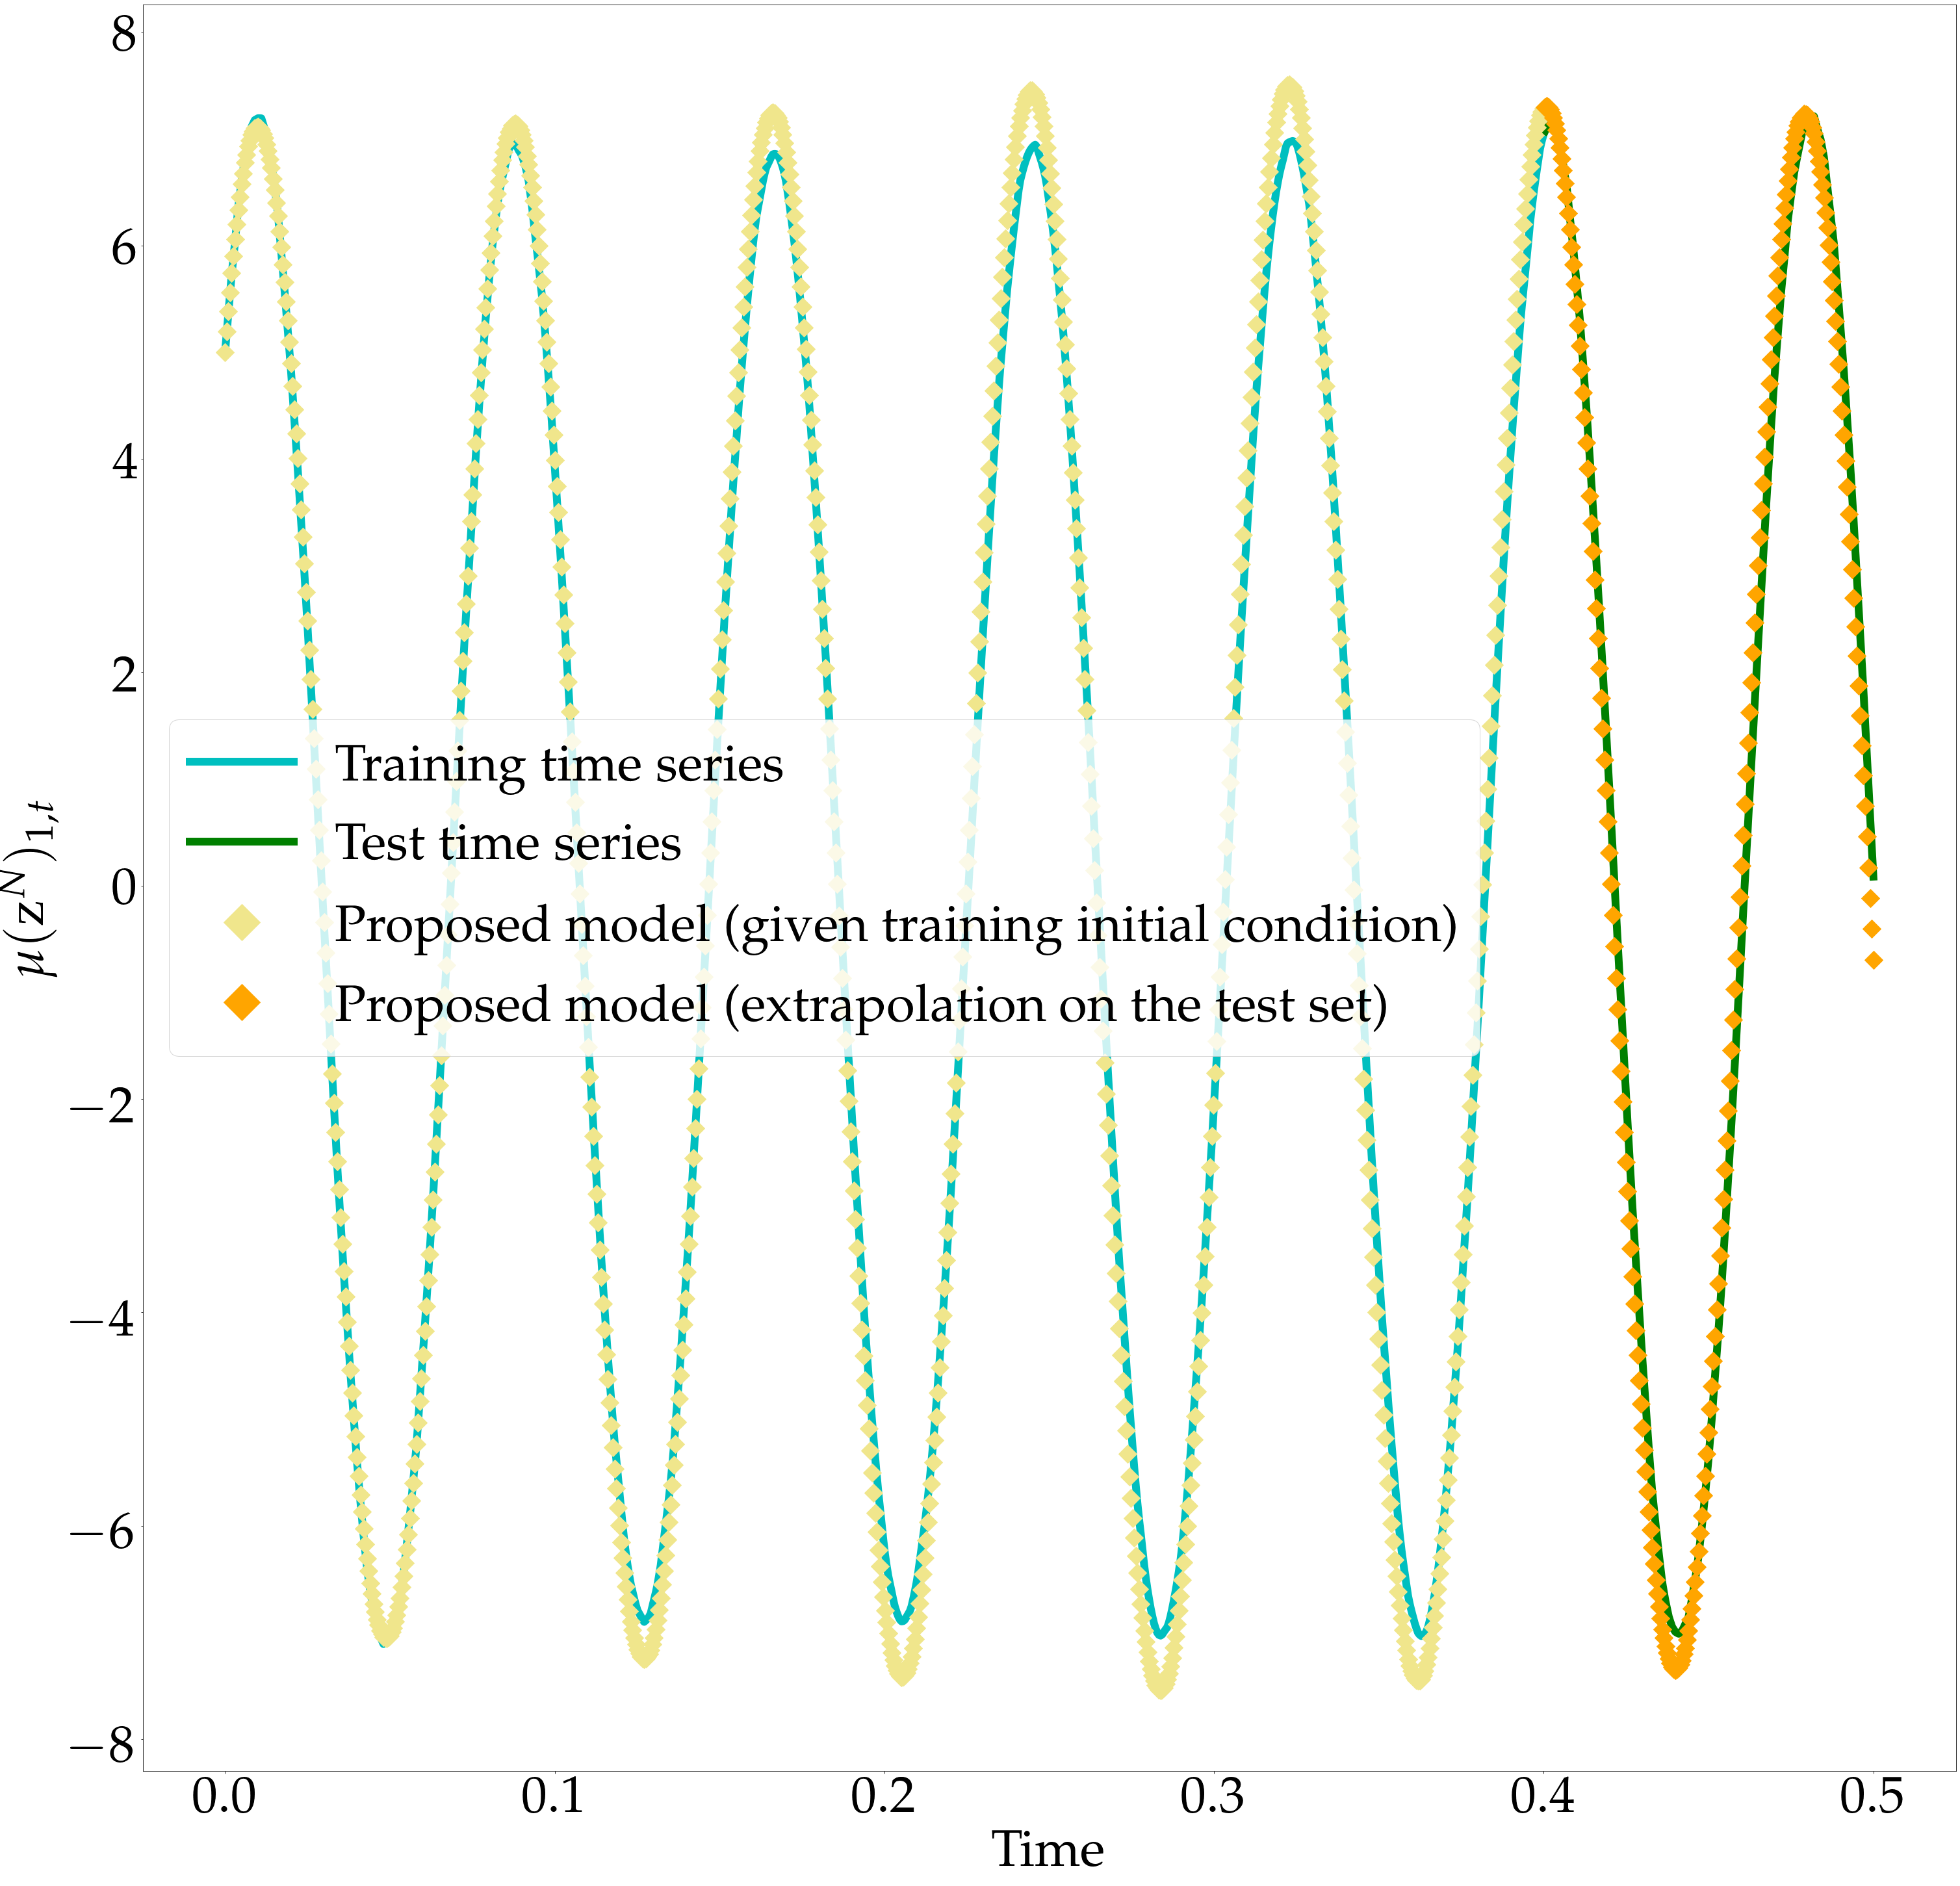

In [12]:
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 80})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fig=plt.figure(figsize=(50,50))

train_series     = np.zeros_like(ys.detach())*np.nan
test_series      = np.zeros_like(ys.detach())*np.nan
predicted_series = np.zeros_like(ys.detach())*np.nan
predicted_series_extrap = np.zeros_like(ys.detach())*np.nan
train_series[:800,:]     = ys.detach()[:800,:] 
test_series[800:,:]      = ys.detach()[800:,:]
predicted_series[:800,:] = y_hat.detach()[:800,:]
predicted_series_extrap[800:,:] = y_hat.detach()[800:,:]

plt.plot(ts,train_series[:,:,0].mean(axis = -1),'c',lw = 12,label = 'Training time series')
plt.plot(ts,test_series[:,:,0].mean(axis = -1),'g',lw = 12,label = 'Test time series')
plt.plot(ts,predicted_series[:,:,0].mean(axis = -1),"D",c = 'khaki',markersize=20,label = 'Proposed model (given training initial condition)')
plt.plot(ts,predicted_series_extrap[:,:,0].mean(axis = -1),"D",c = 'orange',markersize=20,label = 'Proposed model (extrapolation on the test set)')

plt.xlabel('Time')
plt.ylabel('$\mu({\mathrm{z}}^N)_{1,t}$')
plt.legend(markerscale=2)

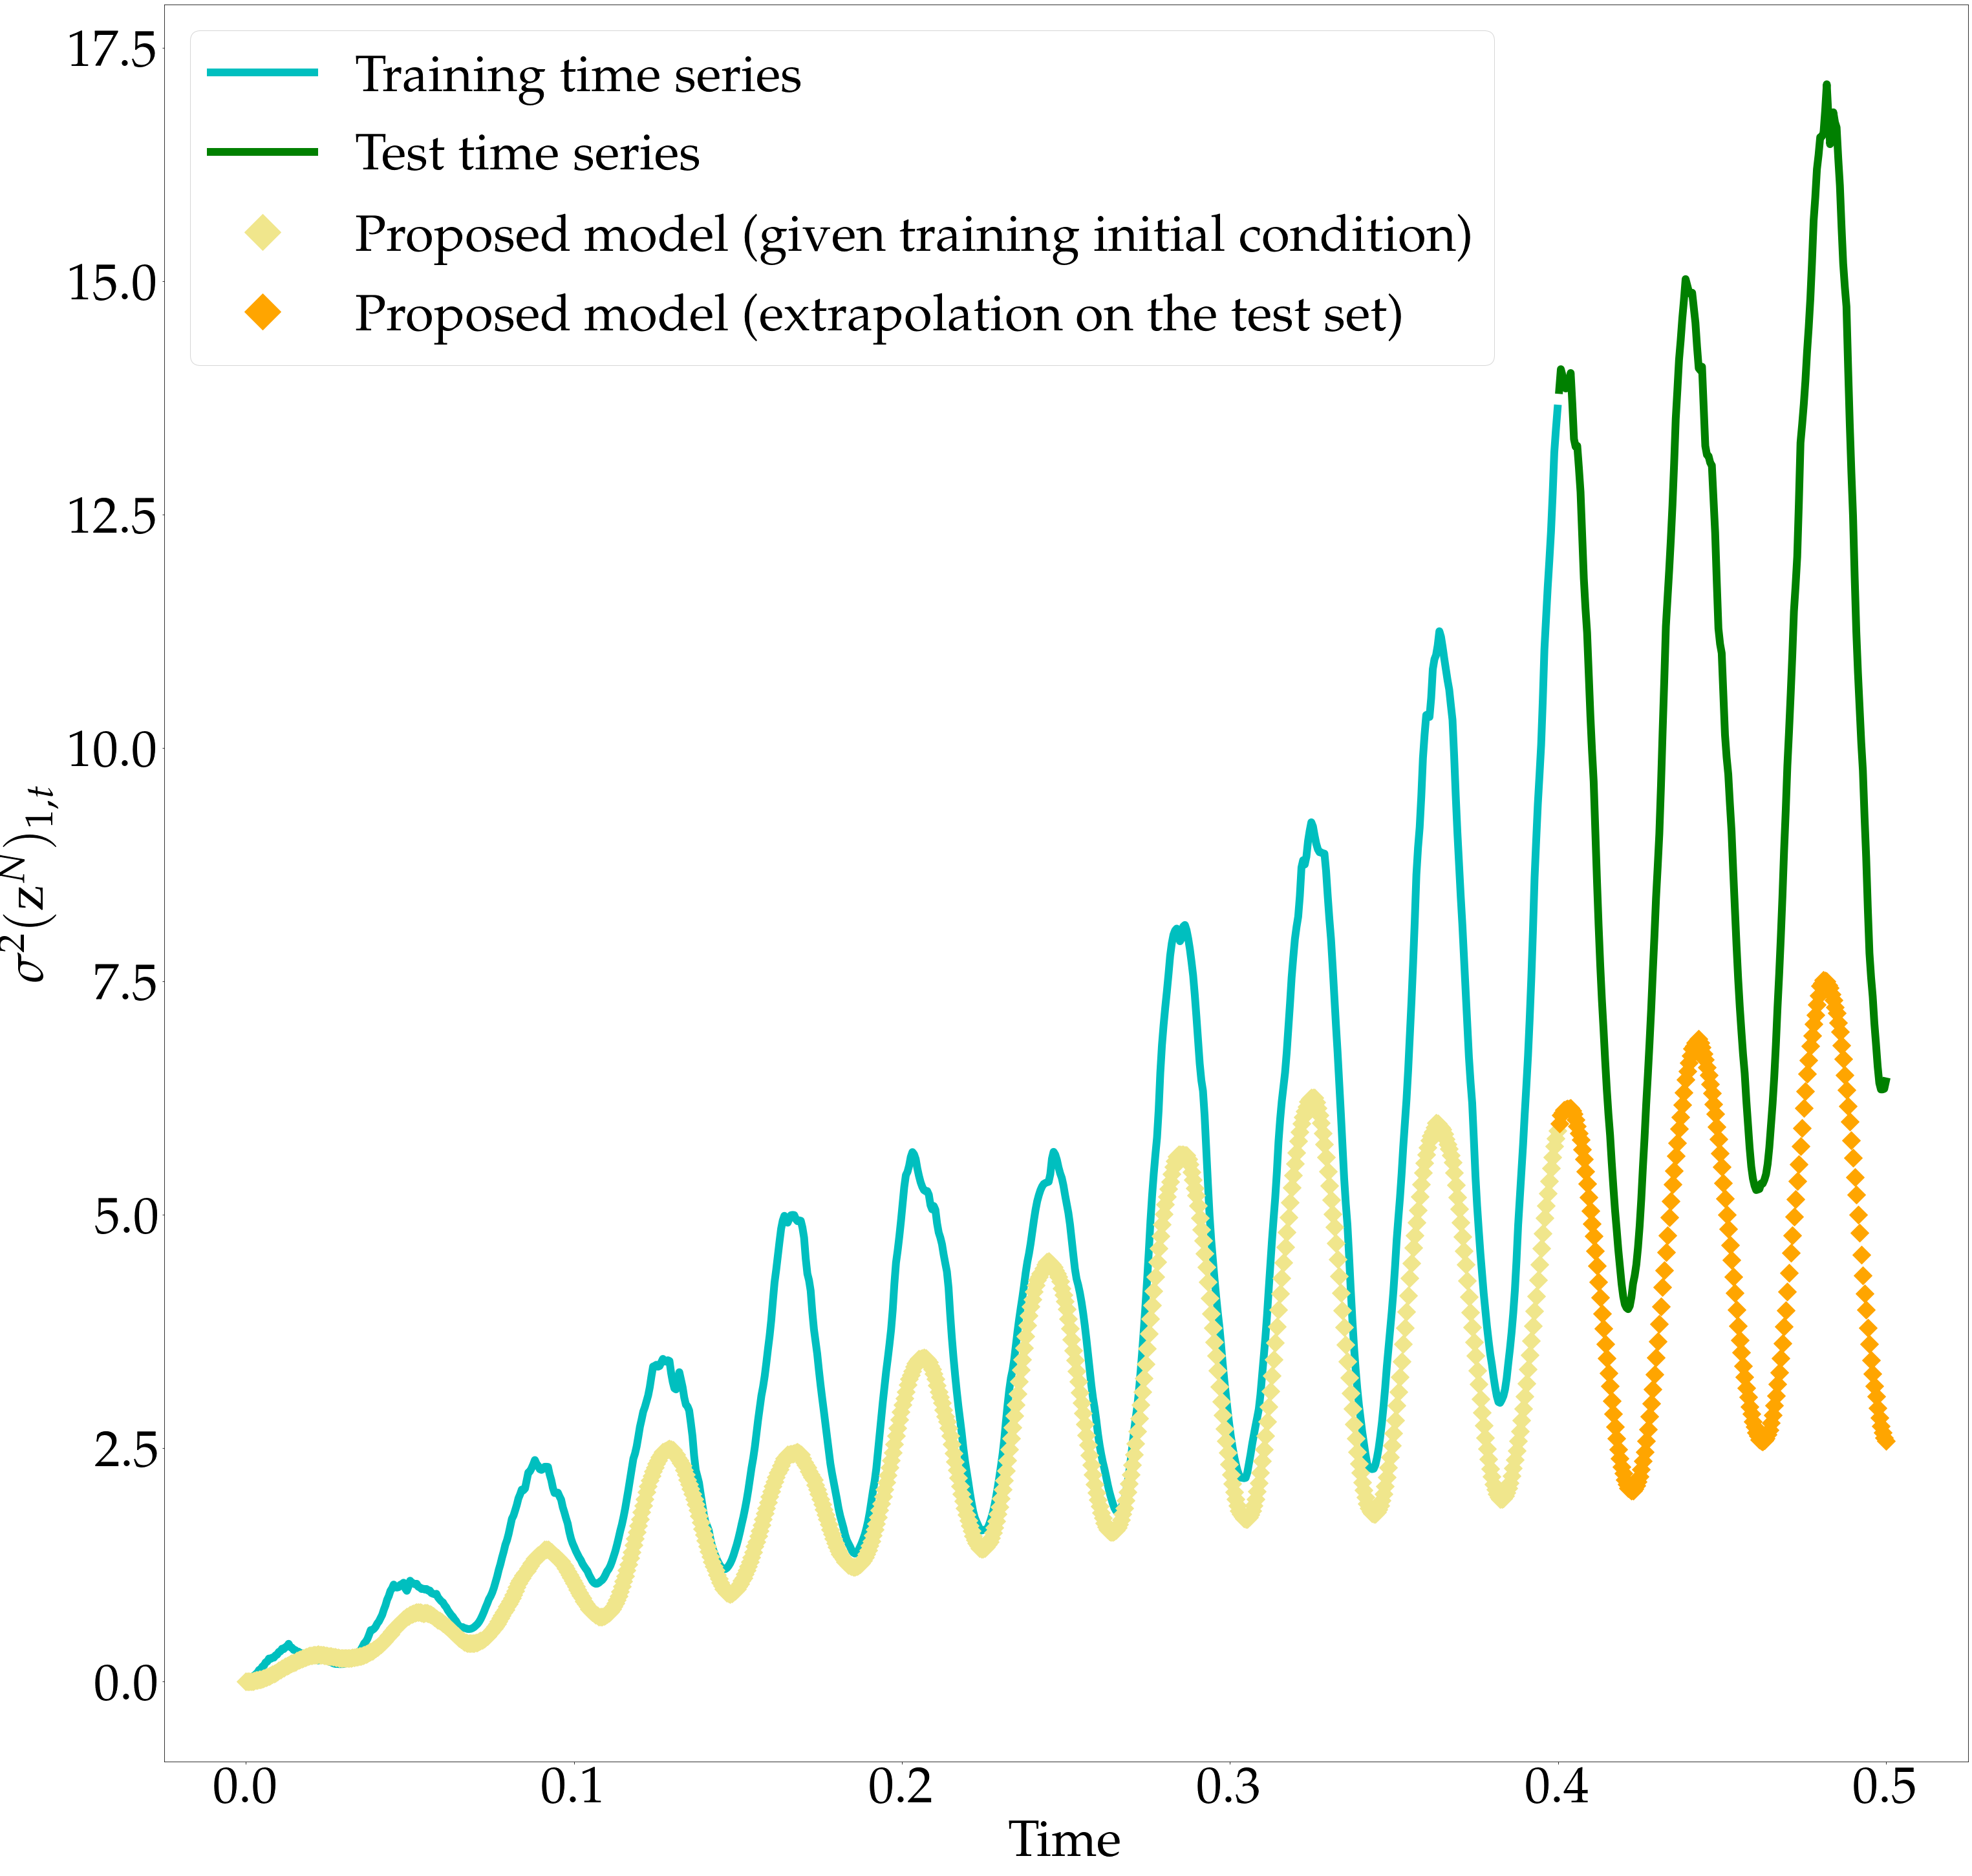

In [13]:
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 80})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fig=plt.figure(figsize=(50,50))

train_series     = np.zeros_like(ys.detach())*np.nan
test_series      = np.zeros_like(ys.detach())*np.nan
predicted_series = np.zeros_like(ys.detach())*np.nan
predicted_series_extrap = np.zeros_like(ys.detach())*np.nan
train_series[:800,:]     = ys.detach()[:800,:] 
test_series[800:,:]      = ys.detach()[800:,:]
predicted_series[:800,:] = y_hat.detach()[:800,:]
predicted_series_extrap[800:,:] = y_hat.detach()[800:,:]

plt.plot(ts,train_series[:,:,0].var(axis = -1),'c',lw = 12,label = 'Training time series')
plt.plot(ts,test_series[:,:,0].var(axis = -1),'g',lw = 12,label = 'Test time series')
plt.plot(ts,predicted_series[:,:,0].var(axis = -1),"D",c = 'khaki',markersize=20,label = 'Proposed model (given training initial condition)')
plt.plot(ts,predicted_series_extrap[:,:,0].var(axis = -1),"D",c = 'orange',markersize=20,label = 'Proposed model (extrapolation on the test set)')

plt.xlabel('Time')
plt.ylabel('$\sigma^2({\mathrm{z}}^N)_{1,t}$')
plt.legend(markerscale=2)